In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Exercise 1: Markov chain on a chessboard

In this exercise, you will implement a Monte Carlo Markov chain (MCMC) simulation on a chessboard with a king as the only piece. The king prefers moving to black squares over white squares. You will compute the stationary distribution of the king's position by using MCMC and by using the transition matrix. The king moves according to the following set of rules:

- The king **must** move to one of the valid neighboring squares (up, down, left, right or, diagonals) at each move.
- The king **cannot** move outside of the board.
- The probability of moving to a black square is twice that of moving to a white square.

Below are two examples of the king's possible moves with the transition probabilities, rounded to two decimal places.

![title](chessboard_1.png)
![title](chessboard_2.png)


**1.1** Create a function that takes as input the position of the king as an array of size 2 and returns the position of the king after one move following the process described above. The first element of the position should represent the column (0 for A, 1 for B, and so on) and the second element the line (0 for line 1, 1 for line 2, and so on). You may use python loops. In your code, do **not** compute the full transition matrix.

Hint: It can be helpful to decompose the task by creating a function that determines the color of a given square and a function that gives the neighbors of a given square.

In [2]:
def is_black(coord):
    if (coord[0] + coord[1])%2 ==0 : #black coordinates have an even sum
        return True
    else:
        return False

def get_neighbours_oldversion(coord): #Finally I found a better way to implement that algorithm (see below)
    neighbours = []
    #We will first check the direct neighbours
    if coord[0] < 7:
        neighbours.append([coord[0] + 1, coord[1]]) #down
    if coord[0] > 0:
        neighbours.append([coord[0] -1, coord[1]]) #up 
    if coord[1] < 7:
        neighbours.append([coord[0], coord[1] +1]) #right
    if coord[1] > 0:
        neighbours.append([coord[0], coord[1] -1]) #left
    #Now we are checking diagonals
    if coord[0] < 7 and coord[1] < 7:  # Down-right
        neighbours.append([coord[0] + 1, coord[1] + 1])
    if coord[0] < 7 and coord[1] > 0:  # Down-left
        neighbours.append([coord[0] + 1, coord[1] - 1])
    if coord[0] > 0 and coord[1] < 7:  # Up-right
        neighbours.append([coord[0] - 1, coord[1] + 1])
    if coord[0] > 0 and coord[1] > 0:  # Up-left
        neighbours.append([coord[0] - 1, coord[1] - 1])
    return neighbours

def get_neighbours(coord):

    moves = [(-1, -1), (-1, 0), (-1, 1), (0, -1),(0, 1), (1, -1), (1, 0), (1, 1)]
    
    neighbours = []
    for dx, dy in moves:
        new_x, new_y = coord[0] + dx, coord[1] + dy
        if 0 <= new_x < 8 and 0 <= new_y < 8:
            neighbours.append([new_x, new_y])
    return neighbours


In [3]:
#Let's do some tests:
print(get_neighbours([0,0]))
print(get_neighbours([3,3]))
print(get_neighbours([0,6]))
print(get_neighbours([0,7]))
print(get_neighbours([7,7]))


[[0, 1], [1, 0], [1, 1]]
[[2, 2], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3], [4, 4]]
[[0, 5], [0, 7], [1, 5], [1, 6], [1, 7]]
[[0, 6], [1, 6], [1, 7]]
[[6, 6], [6, 7], [7, 6]]


In [4]:
def next_position(current_position):
    
    neighbours = get_neighbours(current_position)
    if not neighbours:  # Check if neighbours list is empty
        raise ValueError(f"No neighbours found for position {current_position}.")    
    weights = []
    for neighbour in neighbours:
        if is_black(neighbour):
            weights.append(2)  # Probability weight for black cells
        else:
            weights.append(1)  # Probability weight for white cells
    
    next_pos = random.choices(neighbours, weights=weights, k=1)[0]
    return next_pos


In [5]:
#Let's try our function :
print(next_position([7,7]))
total_black = 0 
for i in range(100):
    x = next_position([3,3]) #we chose this position since it has the same amount of white neighbours as of black neighbours
    if (is_black(x) == True):
        total_black += 1
print(total_black) #we expect to see aprox. 66 printed if our model is correct
    

[6, 6]
64


**1.2** Estimate the probability of being on each square after 2 moves starting from position A1. To do this, run 10'000 simulations using your code from **1.1**. You can use python loops. Print the estimated probability of the king being in A1, B1 and C3 after 2 moves.

In [6]:
def simulate_probability(start, num_simulations=10000):
    
    count = {}
    
    for _ in range(num_simulations):
        
        pos1 = next_position(start) #first move
        pos2 = next_position(pos1) #second move
        
        pos2_tuple = tuple(pos2)
        if pos2_tuple not in count:
            count[pos2_tuple] = 0
        count[pos2_tuple] += 1
    
    probabilities = {pos: cnt / num_simulations for pos, cnt in count.items()}
    return probabilities

start_position = (0, 0)
probabilities = simulate_probability(start_position, num_simulations=10000)

positions_to_check = [(0, 0), (1, 0), (2, 2)]
for pos in positions_to_check:
    print(f"Probability of being at {pos}: {probabilities.get(pos, 0):.4f}")

Probability of being at (0, 0): 0.2099
Probability of being at (1, 0): 0.0745
Probability of being at (2, 2): 0.0845


**1.3** Create the transition matrix $T$. It should be a $64\times 64$ numpy array, where the indices go over all possible squares of the chessboard in the following order: A1, A2, ..., A8, B1, B2, ..., B8, C1, ..., H1, H2, ..., H8. The element $T_{i,j}$ indicates the probability to go from square $j$ to square $i$. You may use python loops. Print the sum of each column of the matrix you obtain.

In [7]:
def index_to_coordinates(index):
    return index % 8, index // 8

def coordinates_to_index(x, y):
    return y * 8 + x

def create_transition_matrix():

    T = np.zeros((64, 64))
    
    for j in range(64): 
        x, y = index_to_coordinates(j)
        neighbours = get_neighbours([x, y]) 
        
        weights = [2 if is_black(neighbor) else 1 for neighbor in neighbours]
        total_weight = sum(weights)
        
        for neighbor, weight in zip(neighbours, weights):
            i = coordinates_to_index(*neighbor)  
            T[i, j] = weight / total_weight  
    
    return T

T = create_transition_matrix()

column_sums = T.sum(axis=0)
print("Column sums of transition matrix:", column_sums)

Column sums of transition matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**1.4** Suppose the king starts in A1. Print the probability of being on each square after 2 moves (it should be an array of size $64\times 1$ containing the probability to be on each square following the same ordering as above). The output of your print may be truncated. To do the calculation, use the transition matrix you created in **1.3**, and do not use python loops. Your code should fit in a few lines.

In [8]:

P0 = np.zeros(64)
P0[0] = 1  # The king starts at A1

P2 = np.linalg.matrix_power(T, 2) @ P0

print("Probabilities after 2 moves:", P2)

Probabilities after 2 moves: [0.20833333 0.07291667 0.14583333 0.         0.         0.
 0.         0.         0.07291667 0.125      0.07291667 0.
 0.         0.         0.         0.         0.14583333 0.07291667
 0.08333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [9]:
#quick additional check :
column_sums = T.sum(axis=0)
print("Column sums of transition matrix:", column_sums)

Column sums of transition matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**1.5** Obtain the stationary distribution of the Markov chain by computing the eigenvector associated to the eigenvalue 1 of the transition matrix. Normalize the eigenvector as needed to ensure it represents a valid probability distribution. Visualize the distribution using the code provided below.

In [10]:
def compute_stationary_distribution(T):
    
    eigenvalues, eigenvectors = np.linalg.eig(T)
    
    stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)].flatten().real #we use np.isclose bc we could have an eigenvalue not strictly equal to 1 due to some numerical precision
                                                                                   #we flatten bc the output is a 2d array and we know we only have one eigenvector and we use .real in case of nuemrical computation "errors"
    stationary_distribution = stationary_vector / np.sum(stationary_vector)#we normalize it so that it is a correct p.d.f
    
    return stationary_distribution



def visualize_distribution(stationary_dist):
    
    stationary_dist.reshape((8, 8))
    print(stationary_dist.reshape(8,8).shape)
    plt.figure(figsize=(8, 8))
    plt.imshow(stationary_dist.reshape((8,8)).T, cmap='gray_r', interpolation= "nearest", alpha=0.5,origin='upper')
    plt.colorbar(label="Probability")
    plt.title("Stationary Distribution on Chessboard")
    plt.xticks(range(8), [chr(i) for i in range(65, 73)])
    plt.yticks(range(8), range(1, 9))
    plt.gca()
    plt.show()

(8, 8)


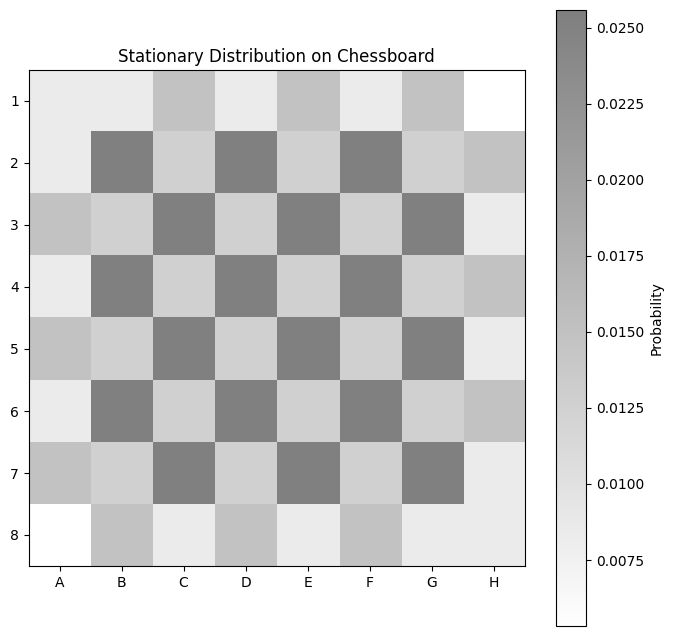

In [11]:
stationary_distribution = compute_stationary_distribution(T)
visualize_distribution(stationary_distribution)

**1.6** Compute and print the convergence time $\tau=-1/\text{log}(\lambda_2)$, where $\lambda_2$ is the second largest eigenvalue.

In [12]:
eigenvalues = np.linalg.eigvals(T)
sorted_eigenvalues = np.sort(np.abs(eigenvalues))[::-1]
    
lambda_2 = sorted_eigenvalues[1]
tau = -1 / np.log(lambda_2)

print(f"Convergence time (tau): {tau:.4f}")

Convergence time (tau): 13.1811


**1.7** As seen in the lecture, we can estimate that after $3\tau$ moves the position of the king should be close to being sampled from the stationary distribution. Run $50'000$ simulations of $3\tau$ moves (rounded to the nearest integer) and, at each move, compute the estimated distribution over the possible positions. The inital position of the king should be taken uniformly over all the possible positions independently for each simulation. You may use python loops.

 Plot the euclidian norm of the difference between the estimated distribution and the stationary distribution obtained in **1.5** as a function of the number of moves. The euclidian norm of the difference is $\sqrt{\sum_{i}(\pi_i^{st}-\pi_i^t)^2}$, where $\pi_i^{st}$ is the probability to be on square $i$ for the stationary distribution, $\pi_i^t$ the estimated probability with the simulations to be on square $i$ after $t$ steps, and the sum is over all possible positions of the chessboard. Additionally, compute the euclidian norm of the difference between the estimated distribution from $50'000$ samples drawn randomly from the true stationary distribution (found in **1.5**) and the stationary distribution itself. Plot this value as a horizontal line on the same plot. For this, do not use a python loop. Hint: use `np.random.choice`.
 
  From this plot, estimate visually after how many moves the distribution stabilizes. Compare to the convergence time $\tau$ computed in **1.6**. Do you need to go through each squares of the chessboard at least once to sample from the stationary distribution ?

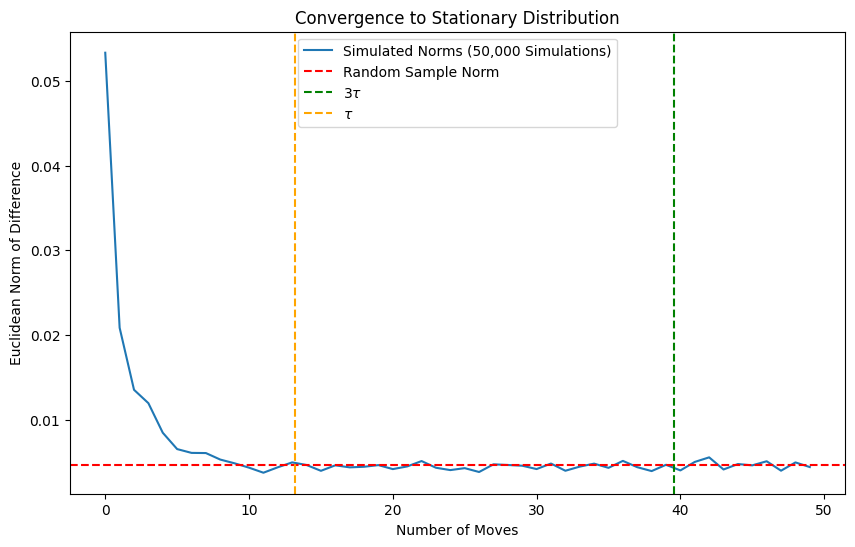

In [13]:
def simulate_king_positions(stationary_distribution, tau, num_simulations=50000):
    
    num_steps = math.ceil(3 * tau + 10)#I added 10 in order to see what happens later on
    num_states = 64  

   
    if stationary_distribution.size != num_states:
        raise ValueError(f"Stationary distribution must have {num_states} elements. Got {stationary_distribution.size}.")#I used it bc I had a lot of buggs

    
    counts = np.zeros((num_steps, num_states))

    for _ in range(num_simulations):
        
        current_position = np.random.randint(0, num_states)#intitial random position

        for t in range(num_steps):
            counts[t, current_position] += 1

            current_coords = index_to_coordinates(current_position)
            neighbours = get_neighbours(current_coords)
            if not neighbours:
                raise ValueError(f"No neighbours found for position {current_position}.") #this help me debugg my code
            next_coords = next_position(current_coords)
            current_position = coordinates_to_index(next_coords[0], next_coords[1])

    estimated_distributions = counts / num_simulations
    
    euclidean_norms = np.sqrt(np.sum((estimated_distributions - stationary_distribution) ** 2, axis=1))
    return euclidean_norms

simulated_norms = simulate_king_positions(stationary_distribution, tau)

random_samples = np.random.choice(len(stationary_distribution), size=50000, p=stationary_distribution)
sample_counts = np.bincount(random_samples, minlength=len(stationary_distribution))
sample_distribution = sample_counts / 50000
random_sample_norm = np.sqrt(np.sum((sample_distribution - stationary_distribution) ** 2))

plt.figure(figsize=(10, 6))
plt.plot(simulated_norms, label="Simulated Norms (50,000 Simulations)")
plt.axhline(random_sample_norm, color='red', linestyle='--', label="Random Sample Norm")
plt.axvline((3 * tau), color='green', linestyle='--', label=r"$3\tau$")
plt.axvline(tau, color = 'orange', linestyle = '--', label = r"$\tau$")
plt.xlabel("Number of Moves")
plt.ylabel("Euclidean Norm of Difference")
plt.title("Convergence to Stationary Distribution")
plt.legend()
plt.show()

### Answer to the Question:

from the plot we can estimate the convergence time to approximatly **9-10 moves** the convergence $\tau$ = 13.18 found earlier seems then a bit conservative in our case. 

The king doesn't need to visit every square on the chessboard to sample from the stationary distribution. This is because the stationary distribution represents the long-term probabilities of being on each square, and these probabilities emerge naturally from the Markov process without requiring full coverage of the state space. (Markov sampling mixes the probabilities across states over time)



## Exercise 2: Sampling hard spheres in 1 dimension

In this exercise, we want to sample from the uniform distribution of $K$ hard spheres on the 1-dimensional interval $[0,L]$. Calling the spheres "hard" means that they cannot overlap in the range of their radius $R$ with other spheres or the border. The position of the center of the sphere $i$ is denoted $x_i\in \mathbb{R}$. This is illustrated in the figure below for $K=2$ spheres, where the first configuration is a valid configuration, and the second and third examples are invalid configurations (in the 2nd a sphere overlaps the border, and in the third the 2 spheres overlap).

Sampling uniformly means that, for the allowed position $x_1, x_2, ..., x_K$, the joint probability density $\rho(x_1, x_2, ..., x_K)=c$ is a constant, and is $0$ for the positions that are not allowed.

![title](hard_spheres.png)

**2.1** Write the mathematical condition such that the spheres do not overlap the border.


$$
R \leq x_i \leq L - R
$$



**2.2** Write the mathematical condition such that each sphere does not overlap with other spheres.

$$
|x_i - x_j| \geq 2R \quad \text{for all} \ i \neq j.
$$

We will now consider the case with $K=2$ spheres.

**2.3** Write a function that takes as input a position of the sphere $x$, the radius of the sphere $R$ and the length of the interval $L$ and returns true if the sphere does **not** overlap with the border, and false in other cases.

In [14]:
def is_within_border(x, R, L):
   return R <= x <= (L - R)

**2.4** Write a function that takes as input two position of the spheres $x_1$, $x_2$ and the radius of the sphere $R$ and returns true if the spheres do **not** overlap, and false in other cases.

In [15]:
def do_not_overlap(x1, x2, R):
    return abs(x1 - x2) >= 2 * R

**2.5** We consider the following sampling algorithm (algorithm A):
1. Sample $x_1$ from the uniform distribution of positions that do not overlap with the border.
2. Sample $x_2$ uniformly from the positions that do not overlap with the border and with the first sphere.
3. Return $x_1$ and $x_2$

Code a function that samples $N$ positions using algorithm A. Your function should take as input the number of desired samples $N$, the length of the interval $L$ and the radius of the spheres $R$. The output should be a numpy array of shape (N,2). You will not be penalized by the use of python loops.


In [16]:
def sample_positions_A(N, L, R):
    
    samples = np.zeros((N, 2))

    for i in range(N):
        x1_min, x1_max = R, L - R
        x1 = np.random.uniform(x1_min, x1_max)

        # Left range: [R, x1 - 2R]
        left_range_min = R
        left_range_max = x1 - 2 * R
        left_length = max(0, left_range_max - left_range_min)

        # Right range: [x1 + 2R, L - R]
        right_range_min = x1 + 2 * R
        right_range_max = L - R
        right_length = max(0, right_range_max - right_range_min)

        total_length = left_length + right_length

        if total_length == 0:
            x2 = np.nan  # This should not happen with reasonable L and R
        else:
            u = np.random.uniform(0, total_length)

            if u < left_length:
                x2 = left_range_min + u
            else:
                x2 = right_range_min + (u - left_length)

        samples[i] = [x1, x2]
    
    return samples


**2.6** Consider an alternative sampling algorithm (algorithm B):
1. Generate $x_1$ and $x_2$ from the uniform distribution of positions that do not overlap with the border.
2. If the two sphere with position $x_1$ and $x_2$ do not overlap, return $x_1$ and $x_2$. Otherwise, start again from step 1.

Code a function that samples $N$ positions using algorithm B. Your function should take as input the number of desired samples $N$, the length of the interval $L$ and the radius of the spheres $R$. The output should be a numpy array of shape (N,2). You will not be penalized by the use of python loops.


In [17]:
def sample_positions_B(N, L, R):
    
    samples = np.zeros((N, 2))

    for i in range(N):
        while True:
            x1 = np.random.uniform(R, L - R)
            x2 = np.random.uniform(R, L - R)

            if do_not_overlap(x1, x2, R):
                samples[i] = [x1, x2]
                break
    
    return samples

**2.7** Sample $N=10^6$ positions using algorithm A and B with parameters $L=1$ and $R=0.1$. Plot a 2D histogram to visualize the estimated joint density $\rho(x_1, x_2)$. The position $x_1$ should be on the x-axis, the position $x_2$ on the y-axis, and the color should indicate the density. The plotted range of $x_1$ and $x_2$ should be $[0,L]$. You should have one figure for algorithm A and one figure for algorithm B. Plot these two figures side by side (for example using `plt.subplot`). Choose an appropriate number of bins for the histogram, and label the figures appropriatly.

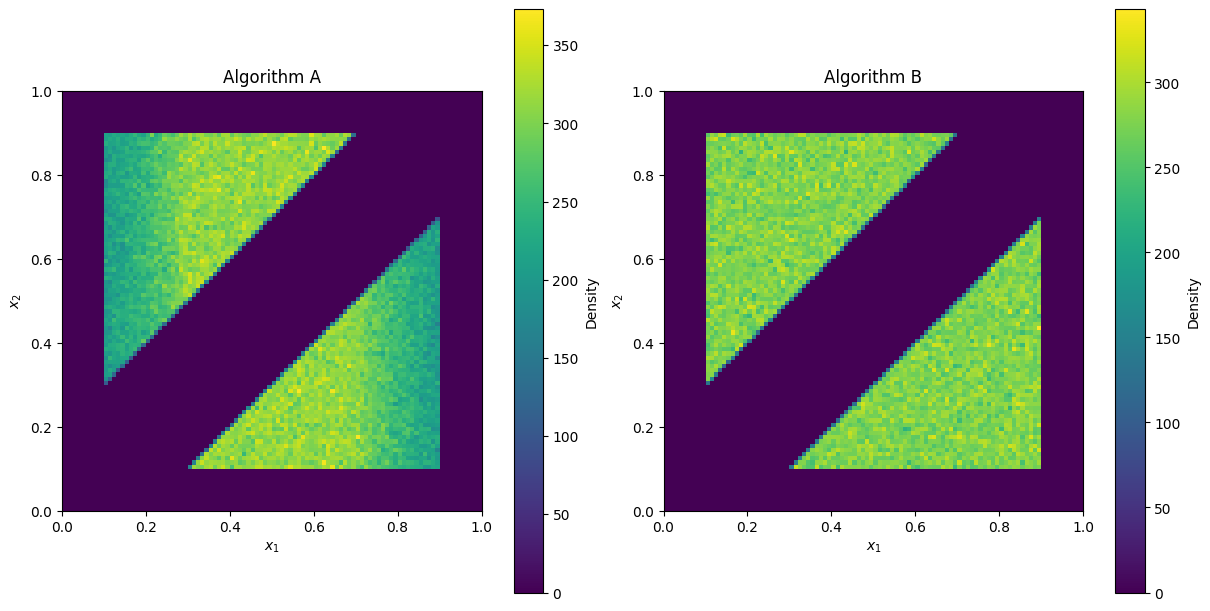

In [18]:
N = 10**6  
L = 1      
R = 0.1    

samples_A = sample_positions_A(N, L, R)
samples_B = sample_positions_B(N, L, R)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

#Algo A
axes[0].hist2d(samples_A[:, 0], samples_A[:, 1], bins=100, range=[[0, L], [0, L]], cmap='viridis')
axes[0].set_title('Algorithm A')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_aspect('equal')

#Algo B
axes[1].hist2d(samples_B[:, 0], samples_B[:, 1], bins=100, range=[[0, L], [0, L]], cmap='viridis')
axes[1].set_title('Algorithm B')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_aspect('equal')


plt.colorbar(axes[0].collections[0], ax=axes[0], label='Density')
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Density')
plt.show()


**2.8** Based on your figure from **1.7**, does algorithm A generate uniform samples (i.e. each of the allowed pairs $(x_1, x_2)$ is equiprobable) ? Does algorithm B generate uniform samples ? Justify briefly. 

As the colors indicates the probability density, it is clear from our 2 histograms that algorithm A DOESN't generate uniform samples (lower densities close to the square's side) while B DOES (same colors for all allowed positions. This non-uniformity arrises because Algorithm A samples $x_1$ first and then restricts the range of $x_2$, introducing a bias in the distribution of $(x_1, x_2)$. (This case is treated on p.75-76 of our beloved polycopié)


**2.9** Plot, on the same figure, a 1D histogram of the estimated marginal probability densities $\rho(x_1)$ of $x_1$ and $\rho(x_2)$ of $x_2$ obtained from the $10^6$ samples from **2.7**. The density of $x_1$ should be blue and the density of $x_2$ red. Do this for the samples obtained for algorithm A and algorithm B, and plot both figures side by side (again, for this you can use `subplot`). Label the figures appropriatly.

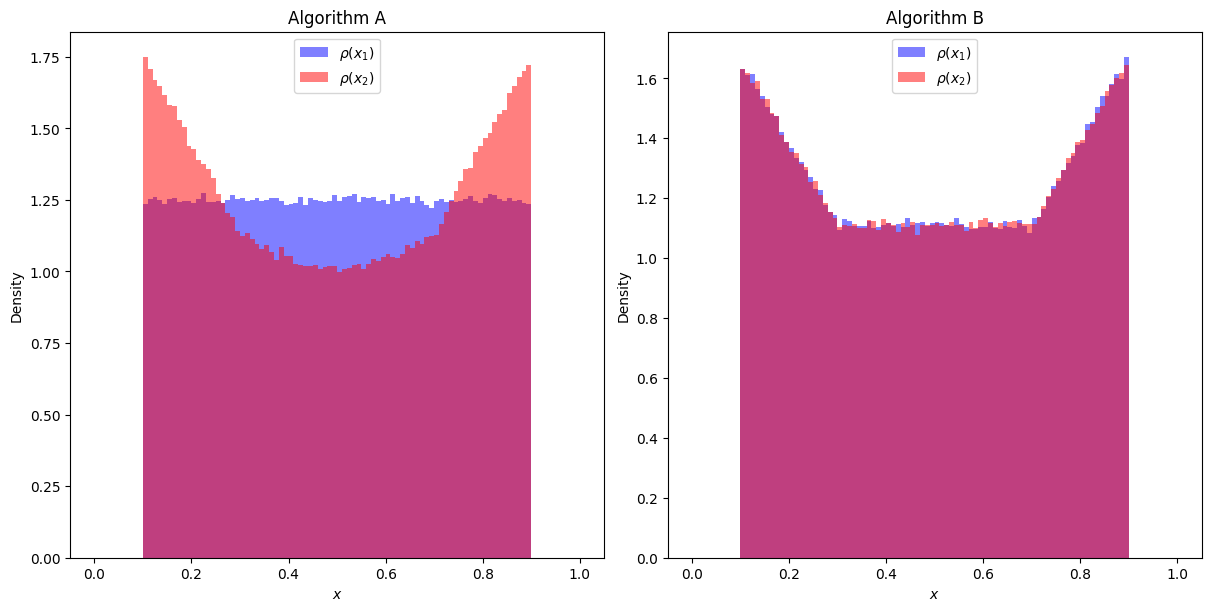

In [19]:
x1_A, x2_A = samples_A[:, 0], samples_A[:, 1]
x1_B, x2_B = samples_B[:, 0], samples_B[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

#Algo A
axes[0].hist(x1_A, bins=100, range=(0, L), density=True, alpha=0.5, color='blue', label=r'$\rho(x_1)$')
axes[0].hist(x2_A, bins=100, range=(0, L), density=True, alpha=0.5, color='red', label=r'$\rho(x_2)$')
axes[0].set_title('Algorithm A')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('Density')
axes[0].legend()

#Algo B
axes[1].hist(x1_B, bins=100, range=(0, L), density=True, alpha=0.5, color='blue', label=r'$\rho(x_1)$')
axes[1].hist(x2_B, bins=100, range=(0, L), density=True, alpha=0.5, color='red', label=r'$\rho(x_2)$')
axes[1].set_title('Algorithm B')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('Density')
axes[1].legend()


plt.show()

**2.10** Based on the previous figure, are the marginal densities $\rho(x_1)$ and $\rho(x_2)$ uniform ? Answer for both the case of algorithm A and B.

**A :**
We see that $\rho(x_1)$ is uniform (not surprising as we explicily set it that way) but $\rho(x_2)$ is not 
**B :**
We see that both $\rho(x_1)$ and $\rho(x_2)$ are not
uniform.

We will now consider the general case with K spheres.

**2.11** Consider the following algorithm (algorithm C):
1. Sample $y_i$ uniformly from the interval $[0, L-2KR]$ for $i=1, ..., K$
2. Order the $y_i$ in ascending order. We denote the ordering of the $y_i$ as $y_1'\leq y_2'\leq...\leq y_K'$.
3. Return $x_i=y_i'+(2i-1)R$ for $i=1,...,K$


Implement algorithm C, which should return a $N\times K$ numpy array containing $N$ samples. Your code should have no python loop.

In [20]:
def sample_positions_C(N, K, L, R):
    
    y = np.random.uniform(0, L - 2 * K * R, size=(N, K))

    y_sorted = np.sort(y, axis=1)

    i_indices = np.arange(1, K + 1) 
    x = y_sorted + (2 * i_indices - 1) * R 

    return x

**2.12** Is algorithm C more efficient than algorithm B ? Briefly justify. Only a qualitative justification is needed.

Algorithm C is more efficient than Algorithm B because it eliminates the need for rejection sampling. Algorithm C always produces valid configurations (because by sorting the $y_i$ values and adding the correction term $(2i - 1)R$, it deterministically constructs valid, non-overlapping configurations), while Algorithm B becomes inefficient as $K$ or $R$ increases. (because it would compute a lot of rejected samples that are useless calculation)


**2.13** Consider $K=2$. Sample $N=10^6$ pairs of positions. Plot the histogram for the estimated marginal probability $\rho(x)$. Label it appropriatly. Is your figure closer to the histogram of algorithm A or B ? 

Important note: algorithm C as described returns the _ordered_ positions of the spheres. Thus, either:
- Swap $x_1$ and $x_2$ with 50% probability for each sample and plot your estimation of $\rho(x_1)$ and $\rho(x_2)$ as done in **1.9**
- OR plot the estimation of $\rho(x)$, where you use the obtained $x_1$ as well as $x_2$ to estimate $\rho(x)$. Hint: in this case flatten the result.

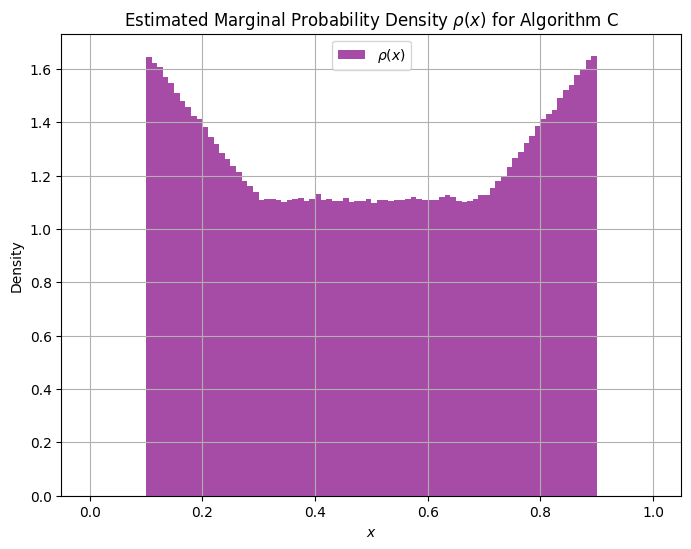

In [21]:
K = 2    

samples_C = sample_positions_C(N, K, L, R)
x_flat = samples_C.flatten()

plt.figure(figsize=(8, 6))
plt.hist(x_flat, bins=100, range=(0, L), density=True, color='purple', alpha=0.7, label=r'$\rho(x)$')
plt.title(r'Estimated Marginal Probability Density $\rho(x)$ for Algorithm C')
plt.xlabel('$x$')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

We are of course closer to algorithm B 's histogram. 

**2.14** Consider the case $K=15$, $L=2$, $R=0.05$ and $N=10^6$. Plot a histogram of the estimated marginal probability density $\rho(x)$ obtained with algorithm C. Label it appropriatly. 

Note: similarly as above, the output of algorithm C are the _ordered_ positions. As the spheres are the same, use all the sampled position to plot the density.

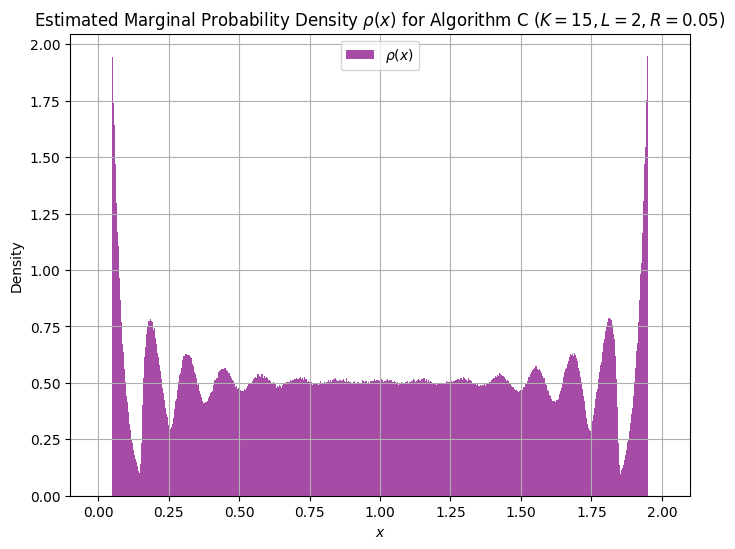

In [22]:
N = 10**6  
K = 15     
L = 2     
R = 0.05   

samples_C = sample_positions_C(N, K, L, R)

x_flat = samples_C.flatten()

plt.figure(figsize=(8, 6))
plt.hist(x_flat, bins=1000, range=(0, L), density=True, color='purple', alpha=0.7, label=r'$\rho(x)$')
plt.title(r'Estimated Marginal Probability Density $\rho(x)$ for Algorithm C ($K=15, L=2, R=0.05$)')
plt.xlabel(r'$x$')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

## SOURCES :
I have ponctually used chat gpt but haven't discussed with anyone about this exercice